#### Generate river input files on ocean grid

Currently the CESM ocean component (either MOM6 or POP) reads in riverine fluxes and adds them to surface fluxes returned from MARBL.
Matt Long has river inputs on the `rJRA025` and `rx1` runoff grids, generated by scripts in the [`cgd-os` repo](https://github.com/NCAR/cgd-os).
For each pair of runoff and ocean grids, we use the same runoff -> ocean map as CESM.

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import os

import xarray as xr
import numpy as np

from MappingClass import ESMFMappingWrapper

date_str = datetime.now().strftime("%Y%m%d")
full_date = '-'.join((date_str[:4], date_str[4:6], date_str[6:]))
print(f'xarray: {xr.__version__}')
print(f'numpy: {np.__version__}')
print(f'date string: {date_str}')

xarray: 2023.6.0
numpy: 1.24.4
date string: 20231211


In [2]:
# User name appears in netCDF metadata
user_full_name = 'M. Levy'

# The source grid is the runoff grid
# src_grid = 'rx1'
src_grid = 'rJRA025'

# The destination grid is the ocean grid
# dst_grid = 'tx0.66v1'
dst_grid = 'tx2_3v2'

In [3]:
runoff_data = dict()
mapping_dict = dict()
mapping_suffix = dict()
out_file = dict()
rof_grids = ['rx1', 'rJRA025']

for rof_grid in rof_grids:
    mapping_dict[rof_grid] = dict()
    mapping_suffix[rof_grid] = dict()
    out_file[rof_grid] = dict()

# Store location of runoff data
runoff_data['rx1'] = os.path.join(os.sep, 'glade', 'work', 'mclong', 'cesm_inputdata', 'work', 'river_nutrients.GNEWS_GNM.daitren_rx1.20190602.nc')
runoff_data['rJRA025'] = os.path.join(os.sep, 'glade', 'work', 'mclong', 'cesm_inputdata', 'work', 'river_nutrients.GNEWS_GNM.JRA55.20190602.nc')

# Store location of mapping files
root_dir = os.path.join(os.sep, 'glade', 'campaign', 'cesm', 'cesmdata', 'inputdata', 'cpl', 'gridmaps')
# rx1 -> tx0.66v1
suffix = 'nnsm_e1000r300_190315'
mapping_suffix['rx1']['tx0.66v1'] = suffix
mapping_dict['rx1']['tx0.66v1'] = os.path.join(root_dir, 'rx1', f'map_rx1_to_tx0.66v1_{suffix}.nc')
# JRA025 -> tx0.66v1
suffix = 'nnsm_e333r100_190910'
mapping_suffix['rJRA025']['tx0.66v1'] = suffix
mapping_dict['rJRA025']['tx0.66v1'] = os.path.join(root_dir, 'rJRA025', f'map_JRA025m_to_tx0.66v1_{suffix}.nc')
# JRA025 -> tx2_3v2
suffix = 'nnsm_e333r100_230415'
mapping_suffix['rJRA025']['tx2_3v2'] = suffix
mapping_dict['rJRA025']['tx2_3v2'] = os.path.join(os.sep, 'glade', 'work', 'gmarques', 'cesm', 'tx2_3', 'runoff_mapping', f'map_jra_to_tx2_3_{suffix}.nc')

# Names for netcdf output
for rof_grid in rof_grids:
    for ocn_grid in mapping_dict[rof_grid]:
        out_file[rof_grid][ocn_grid] = f'riv_nut.gnews_gnm.{rof_grid}_to_{ocn_grid}_{mapping_suffix[rof_grid][ocn_grid]}.{date_str}.nc'

out_file[src_grid][dst_grid]

'riv_nut.gnews_gnm.rJRA025_to_tx2_3v2_nnsm_e333r100_230415.20231211.nc'

In [4]:
out_vars = [
            'din_riv_flux',
            'dip_riv_flux',
            'don_riv_flux',
            'dop_riv_flux',
            'dsi_riv_flux',
            'dfe_riv_flux',
            'dic_riv_flux',
            'alk_riv_flux',
            'doc_riv_flux'
           ]

ds_roff = xr.open_dataset(runoff_data[src_grid], decode_times=False)[out_vars]
ds_roff

<xarray.Dataset>
Dimensions:       (time: 21, lat: 720, lon: 1440)
Coordinates:
  * lat           (lat) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon           (lon) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time          (time) float64 6.933e+05 6.951e+05 ... 7.28e+05 7.298e+05
Data variables:
    din_riv_flux  (time, lat, lon) float64 ...
    dip_riv_flux  (time, lat, lon) float64 ...
    don_riv_flux  (time, lat, lon) float64 ...
    dop_riv_flux  (time, lat, lon) float64 ...
    dsi_riv_flux  (time, lat, lon) float64 ...
    dfe_riv_flux  (time, lat, lon) float64 ...
    dic_riv_flux  (time, lat, lon) float64 ...
    alk_riv_flux  (time, lat, lon) float64 ...
    doc_riv_flux  (time, lat, lon) float64 ...
Attributes:
    author:                          Created by M. Long
    creation_date:                   2019-06-02
    procedure:                       Data sets are first interpolated to a ru...
    source:                          Blend of GlobalNEWS and IMAGE-GNM data: ...
    assumptions_alk:                 Dissolved inorganic carbon (DIC) in fres...
    assumptions_Fe:                  Since iron loads are not available, we a...
    assumptions_DIP:                 We assume that 25% of particulate phosph...
    assumptions_NP_pools:            The IMAGE-GNM dataset provide time-varyi...
    assumptions_NP_pools_fractions:  DIN fraction = 0.4699; DON fraction = 0....

In [5]:
mapping_obj = ESMFMappingWrapper(mapping_dict[src_grid][dst_grid])
da_out = mapping_obj.map_var(ds_roff, out_vars[0])
ds = da_out.to_dataset()
for var in out_vars:
    if var in ds:
        continue
    ds[var] = mapping_obj.map_var(ds_roff, var)

din_riv_flux stats: sums are 1.802e+01 (native) and 1.801e+01 (mapped); rel_err is 6.970e-04
din_riv_flux stats: sums are 3.428e+01 (native) and 3.427e+01 (mapped); rel_err is 3.275e-04
dip_riv_flux stats: sums are 2.597e-02 (native) and 2.593e-02 (mapped); rel_err is 1.475e-03
dip_riv_flux stats: sums are 4.540e-02 (native) and 4.536e-02 (mapped); rel_err is 8.307e-04
don_riv_flux stats: sums are 9.278e+00 (native) and 9.272e+00 (mapped); rel_err is 6.970e-04
don_riv_flux stats: sums are 1.765e+01 (native) and 1.765e+01 (mapped); rel_err is 3.275e-04
dop_riv_flux stats: sums are 4.968e-03 (native) and 4.961e-03 (mapped); rel_err is 1.475e-03
dop_riv_flux stats: sums are 8.687e-03 (native) and 8.680e-03 (mapped); rel_err is 8.307e-04
dsi_riv_flux stats: sums are 4.991e+00 (native) and 4.988e+00 (mapped); rel_err is 7.342e-04
dsi_riv_flux stats: sums are 4.991e+00 (native) and 4.988e+00 (mapped); rel_err is 7.342e-04
dfe_riv_flux stats: sums are 3.793e-01 (native) and 3.784e-01 (mapped)

In [6]:
# Update time attributes
ds['time'].attrs = ds_roff['time'].attrs
ds['time'].attrs['axis'] = 'T'
ds['time'].attrs['cartesian_axis'] = 'T'
ds['time'].encoding['_FillValue'] = None

# Update global attributes
ds.attrs['author'] = f'Created by {user_full_name}'
ds.attrs['creation_date'] = full_date
ds.attrs['procedure'] = 'Data sets are first interpolated to a runoff grid, then mapped to the ocean with the intention of using the same mapping file as for freshwater runoff.'
ds.attrs['source'] = 'Blend of GlobalNEWS and IMAGE-GNM data: GlobalNEWS: https://marine.rutgers.edu/globalnews/index.htm; IMAGE-GNM: https://easy.dans.knaw.nl/ui/datasets/id/easy-dataset:64145'
for attr in ds_roff.attrs:
    if 'assumption' in attr:
        ds.attrs[attr] = ds_roff.attrs[attr]
ds.attrs['mapping_src_file'] = runoff_data[src_grid]
ds.attrs['mapping_file'] = mapping_dict[src_grid][dst_grid]
ds

<xarray.Dataset>
Dimensions:       (time: 21, y: 480, x: 540)
Coordinates:
  * time          (time) float64 6.933e+05 6.951e+05 ... 7.28e+05 7.298e+05
Dimensions without coordinates: y, x
Data variables:
    din_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dip_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    don_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dop_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dsi_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dfe_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dic_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    alk_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    doc_riv_flux  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    author:                          Created by M. Levy
    creation_date:                   2023-12-11
    procedure:                       Data sets are first interpolated to a ru...
    source:                          Blend of GlobalNEWS and IMAGE-GNM data: ...
    assumptions_alk:                 Dissolved inorganic carbon (DIC) in fres...
    assumptions_Fe:                  Since iron loads are not available, we a...
    assumptions_DIP:                 We assume that 25% of particulate phosph...
    assumptions_NP_pools:            The IMAGE-GNM dataset provide time-varyi...
    assumptions_NP_pools_fractions:  DIN fraction = 0.4699; DON fraction = 0....
    mapping_src_file:                /glade/work/mclong/cesm_inputdata/work/r...
    mapping_file:                    /glade/work/gmarques/cesm/tx2_3/runoff_m...

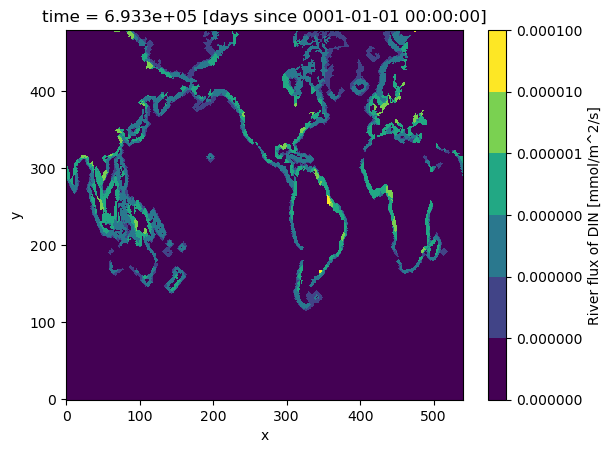

In [7]:
ds.isel(time=0)['din_riv_flux'].plot(levels=[0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4])

In [8]:
ds.to_netcdf(out_file[src_grid][dst_grid], unlimited_dims='time')